## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from ast import literal_eval

import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))

## Opening csv file and removing redundant ID column

In [230]:
df = pd.read_csv('Covid_Papers.csv')

In [231]:
df.drop("Unnamed: 0", axis =1, inplace = True)
df['abstract'] = df['title'] + ' ' + df['abstract']
df.drop("title", axis =1, inplace = True)

In [232]:
df


,abstract,tags
0,Real-World Experience with COVID-19 Including...,"['Aged', 'Aged, 80 and over', 'Antibodies, Mon..."
1,Successful outcome of pre-engraftment COVID-19...,"['COVID-19*', 'Hematopoietic Stem Cell Transpl..."
2,The impact of COVID-19 on oncology professiona...,"['Burnout, Professional* / epidemiology', 'COV..."
3,ICU admission and mortality classifiers for CO...,"['Bayes Theorem', 'COVID-19*', 'Hospitalizatio..."
4,Clinical evaluation of nasopharyngeal midturb...,"['COVID-19 Testing', 'COVID-19* / diagnosis', ..."
...,...,...
5468,Hypersensitivity Reactions to Vaccines Curren...,"['Anaphylaxis* / chemically induced', 'COVID-1..."
5469,Rooming-in Breastfeeding and Neonatal Follow-...,"['Breast Feeding*', 'COVID-19*', 'Female', 'Fo..."
5470,Acute Abducens Nerve Palsy Following the Secon...,['Abducens Nerve Diseases* / chemically induce...
5471,Planning and Implementing the Protocol for Psy...,"['COVID-19*', 'Delivery of Health Care', 'Huma..."


## Creating helper functions to clean text for later

In [233]:
def remove_punctuation(text):
    
    # punctuations except -  
    punc ='''?!.,:;_—[](){}'"`~|\/@#$%^&+=*'''
    for i in text:
        if i in punc:
            text = text.replace(i, ' ')            
    return text.strip()

def preprocess(text):
    
    # lower casing
    text=text.lower()
    
    # stopword removal
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    
    # lemmatization
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')]
    text = " ".join(text)
    
    # removing words containing only numbers
    text = re.sub(r'\s[0-9]+\s', '', text)
    
    # remove extra spaces
    text = re.sub("\s\s+", " ", text)   
    return text.strip()

In [234]:
df.head()

,abstract,tags
0,Real-World Experience with COVID-19 Including...,"['Aged', 'Aged, 80 and over', 'Antibodies, Mon..."
1,Successful outcome of pre-engraftment COVID-19...,"['COVID-19*', 'Hematopoietic Stem Cell Transpl..."
2,The impact of COVID-19 on oncology professiona...,"['Burnout, Professional* / epidemiology', 'COV..."
3,ICU admission and mortality classifiers for CO...,"['Bayes Theorem', 'COVID-19*', 'Hospitalizatio..."
4,Clinical evaluation of nasopharyngeal midturb...,"['COVID-19 Testing', 'COVID-19* / diagnosis', ..."


In [235]:
df['abstract']=df['abstract'].apply(remove_punctuation)
df['abstract']=df['abstract'].apply(preprocess)

In [236]:
df.loc[1][1]

"['COVID-19*', 'Hematopoietic Stem Cell Transplantation*', 'Humans', 'Immunity, Cellular', 'Pandemics', 'SARS-CoV-2']"

## Making column into string literals for easier computation

In [237]:
df["tags"] = df["tags"].apply(
    lambda x: literal_eval(x)
)
df["tags"].values[:5]

array([list(['Aged', 'Aged, 80 and over', 'Antibodies, Monoclonal, Humanized / therapeutic use*', 'Antibodies, Neutralizing / therapeutic use', 'Antigens, Viral / analysis', 'COVID-19 Testing', 'COVID-19* / diagnosis', 'COVID-19* / therapy', 'Hospitals', 'Humans', 'Middle Aged', 'Retrospective Studies', 'South Dakota']),
       list(['COVID-19*', 'Hematopoietic Stem Cell Transplantation*', 'Humans', 'Immunity, Cellular', 'Pandemics', 'SARS-CoV-2']),
       list(['Burnout, Professional* / epidemiology', 'COVID-19* / epidemiology', 'COVID-19* / psychology', 'Europe / epidemiology', 'Female', 'Health Personnel* / psychology', 'Humans', 'Medical Oncology*', 'Pandemics', 'Societies, Medical']),
       list(['Bayes Theorem', 'COVID-19*', 'Hospitalization', 'Humans', 'Intensive Care Units', 'Retrospective Studies', 'SARS-CoV-2']),
       list(['COVID-19 Testing', 'COVID-19* / diagnosis', 'Humans', 'Nasopharynx', 'SARS-CoV-2*', 'Saliva', 'Specimen Handling'])],
      dtype=object)

In [238]:
df['tags'][2]

['Burnout, Professional* / epidemiology',
 'COVID-19* / epidemiology',
 'COVID-19* / psychology',
 'Europe / epidemiology',
 'Female',
 'Health Personnel* / psychology',
 'Humans',
 'Medical Oncology*',
 'Pandemics',
 'Societies, Medical']

## Splitting data into train, val and test

In [239]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(df, test_size=test_split)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

D:\Programming\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [240]:
tags = tf.ragged.constant(train_df["tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(tags)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

## Finding good value for max length (using median value)

In [241]:
train_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    4925.000000
mean      149.356751
std        50.416563
min        27.000000
25%       117.000000
50%       147.000000
75%       177.000000
max       436.000000
Name: abstract, dtype: float64

## Transforming datasets to later vectorise

In [242]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [243]:
test_df

,abstract,tags
5136,viral haplotype covid-19 patient associated pr...,"[COVID-19*, Haplotypes, Humans, Phylogeny, RNA..."
4421,national health nutrition examination survey n...,"[Adult, COVID-19 / epidemiology*, COVID-19 / p..."
4964,explaining age-adjusted excess mortality covid...,"[COVID-19*, Germany / epidemiology, Humans, In..."
3803,prevalence paediatric hyperinflammatory condit...,"[Adolescent, COVID-19 / complications*, COVID-..."
3197,wealth gradient effect covid-19 restriction in...,"[COVID-19*, Communicable Disease Control*, Hea..."
...,...,...
649,nanobody-functionalized cellulose capturing sa...,"[COVID-19*, Cellulose, Communicable Disease Co..."
1670,syngap1-related developmental epileptic enceph...,"[Adolescent, Autism Spectrum Disorder* / compl..."
3038,informality time covid-19 latin america implic...,"[Adolescent, Adult, COVID-19* / epidemiology, ..."
5031,long term predictor breathlessness exercise in...,"[Adolescent, Adult, Aftercare, Aged, COVID-19*..."


In [152]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [153]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10505), dtype=tf.float32, name=None))>

## Creating vocabulary for vectorisation of text and mapping dataset with vectorizer

In [154]:
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

45893


In [155]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/GPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [20]:
train_dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset element_spec=(TensorSpec(shape=(None, 45754), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10575), dtype=tf.float32, name=None))>>

## Dataset now ready to be used

In [156]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 45893), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10505), dtype=tf.float32, name=None))>

## Creating the model

In [157]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(128, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(2048, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

In [158]:
epochs = 5

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss= "binary_crossentropy", optimizer = "adam", metrics=["categorical_accuracy"], 
)

## Training the model

In [159]:
history = shallow_mlp_model.fit(train_dataset, validation_data=validation_dataset, 
                    epochs = epochs,)

Epoch 1/5
39/39 [==============================] - 12s 278ms/step - loss: 0.0610 - categorical_accuracy: 0.9314 - val_loss: 0.0078 - val_categorical_accuracy: 0.4307
Epoch 2/5
39/39 [==============================] - 11s 278ms/step - loss: 0.0076 - categorical_accuracy: 0.9836 - val_loss: 0.0068 - val_categorical_accuracy: 0.4307
Epoch 3/5
39/39 [==============================] - 12s 311ms/step - loss: 0.0059 - categorical_accuracy: 0.9836 - val_loss: 0.0067 - val_categorical_accuracy: 0.4307
Epoch 4/5
39/39 [==============================] - 12s 299ms/step - loss: 0.0054 - categorical_accuracy: 0.9836 - val_loss: 0.0065 - val_categorical_accuracy: 0.4307
Epoch 5/5
39/39 [==============================] - 12s 299ms/step - loss: 0.0051 - categorical_accuracy: 0.9827 - val_loss: 0.0064 - val_categorical_accuracy: 0.4307


## Visuallising our training

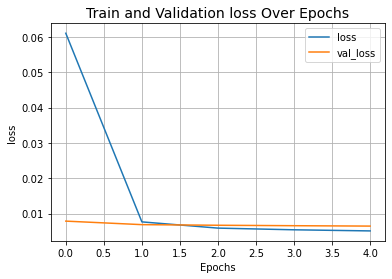

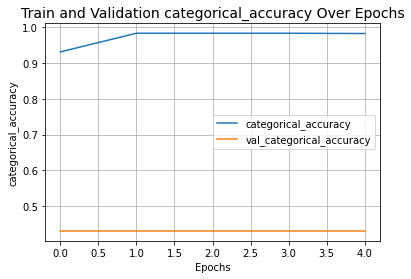

In [160]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Test Accuracy:

In [161]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

3/3 [==============================] - 0s 45ms/step - loss: 0.0061 - categorical_accuracy: 0.4745
Categorical accuracy on the test set: 47.45%.


In [162]:
shallow_mlp_model.save('Auto_tagger.h5')

In [163]:
test_df.iloc[-1]

abstract    occupational risk sars-cov-2 infection reinfec...
tags        [Adult, COVID-19 / diagnosis*, COVID-19 / epid...
Name: 4364, dtype: object

In [164]:
inference_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10575), dtype=tf.float32, name=None))>

In [184]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

abstract = str(input("Enter your abstract you want to tag: "))

df2 = {"abstract": abstract, 'tags': ['Humans']}

test_df = test_df.append(df2, ignore_index = True)

Enter your abstract you want to tag: occupational effect sick covid


In [192]:
test_df

,abstract,tags
0,effect selected inherited factor susceptibilit...,"[ABO Blood-Group System / genetics, Angiotensi..."
1,dynamic mask use prevention strategy sars-cov-...,"[Adolescent, COVID-19*, Humans, Masks, Pandemi..."
2,new mimic relapse regional lymph node metastas...,"[Adult, COVID-19 Vaccines, COVID-19*, Cancer S..."
3,world society virology first international con...,"[COVID-19 / immunology*, COVID-19 / prevention..."
4,impact covid-19 pandemic cancer researcher qua...,"[COVID-19*, Humans, Neoplasms* / epidemiology,..."
...,...,...
272,performance nursing student tele-health servic...,"[COVID-19*, Education, Nursing, Baccalaureate*..."
273,occupational risk sars-cov-2 infection reinfec...,"[Adult, COVID-19 / diagnosis*, COVID-19 / epid..."
274,training clinician care patient homelessness,[]
275,I am so hungry man,[]


In [194]:
# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df, is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

In [195]:
predicted_proba = [proba for proba in predicted_probabilities[i]]

In [196]:
predicted_proba

[0.00023645163,
 0.9709979,
 0.7104189,
 0.7062284,
 0.41364205,
 0.19429827,
 0.17078835,
 0.14369392,
 0.08866188,
 0.104919136,
 0.19684955,
 0.07051155,
 0.16213849,
 0.09497422,
 0.122013986,
 0.068229795,
 0.0642578,
 0.0961023,
 0.04310447,
 0.13176665,
 0.1348786,
 0.105881155,
 0.13829815,
 0.15139973,
 0.093331635,
 0.04145491,
 0.06359276,
 0.039763093,
 0.03522417,
 0.04693237,
 0.030017763,
 0.019621193,
 0.02233994,
 0.017028928,
 0.037086517,
 0.019754559,
 0.08365196,
 0.08237925,
 0.03850591,
 0.07560405,
 0.021364331,
 0.038693577,
 0.03798005,
 0.029052317,
 0.042258084,
 0.044493914,
 0.03860581,
 0.02681005,
 0.067192405,
 0.03593275,
 0.025017023,
 0.026030838,
 0.04939595,
 0.017974973,
 0.030323416,
 0.025488526,
 0.07255569,
 0.027597696,
 0.053705484,
 0.017486632,
 0.027020156,
 0.015305072,
 0.009409785,
 0.027989507,
 0.039071858,
 0.02014032,
 0.029796034,
 0.010712117,
 0.037789434,
 0.026002288,
 0.02919221,
 0.03056255,
 0.047029376,
 0.010192603,
 0.01

In [197]:
label_batch

<tf.Tensor: shape=(128, 10505), dtype=float32, numpy=
array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]], dtype=float32)>

In [206]:
for i, text in enumerate(text_batch[-2:-1]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}" + "\n")
    print(f"Label(s): {invert_multi_hot(label[0])}" + "\n")

Abstract: b'impact covid-19 burden care family people intellectual developmental disability aim study analysed impact covid-19 response measure implemented spanish government family individual intellectual developmental disability method datafamily member 3 year old sd 5 collected online survey focused analysing difficulty experienced service provision lockdown result many family 3 seen level stress increased lockdown among reason greater burden care difficulty associated closure change disability-related service family people extensive support need generally experienced greater difficulty conclusion support service considered essential service lockdown failure receive support resulted excessive burden family assume multitude role support family member intellectual developmental disability'

Label(s): ['[UNK]' 'Humans' 'SARS-CoV-2' 'Antibodies, Viral / immunology'
 'COVID-19* / immunology' 'Lung / virology' 'Lung / immunology'
 'Immunity, Innate*' 'Immunoglobulin A / immunology'
 'Inte

In [198]:
for i, text in enumerate(text_batch[-1:-2]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}" + "\n")
    print(f"Label(s): {invert_multi_hot(label[0])}" + "\n")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_8_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:6]
    print(f"Predicted Label(s): ({', '.join([label for label in top_8_labels])})")
    print(" ")

In [249]:
abstract = str(input("Enter your abstract you want to tag: "))

df2 = {"abstract": [abstract], 'tags': ['']}

df = df.append(df2, ignore_index = True)

Enter your abstract you want to tag: kmk


In [250]:
test_df

,abstract,tags
5136,viral haplotype covid-19 patient associated pr...,"[COVID-19*, Haplotypes, Humans, Phylogeny, RNA..."
4421,national health nutrition examination survey n...,"[Adult, COVID-19 / epidemiology*, COVID-19 / p..."
4964,explaining age-adjusted excess mortality covid...,"[COVID-19*, Germany / epidemiology, Humans, In..."
3803,prevalence paediatric hyperinflammatory condit...,"[Adolescent, COVID-19 / complications*, COVID-..."
3197,wealth gradient effect covid-19 restriction in...,"[COVID-19*, Communicable Disease Control*, Hea..."
...,...,...
649,nanobody-functionalized cellulose capturing sa...,"[COVID-19*, Cellulose, Communicable Disease Co..."
1670,syngap1-related developmental epileptic enceph...,"[Adolescent, Autism Spectrum Disorder* / compl..."
3038,informality time covid-19 latin america implic...,"[Adolescent, Adult, COVID-19* / epidemiology, ..."
5031,long term predictor breathlessness exercise in...,"[Adolescent, Adult, Aftercare, Aged, COVID-19*..."


In [ ]:
testing_ds = make_dataset()

In [248]:
type(text_batch)

tensorflow.python.framework.ops.EagerTensor

In [246]:
model_for_inference.predict("corona virus")

IndexError: list index out of range

## Testing how the model tags data

In [244]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(10), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:8]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}" + "\n")
    print(f"Label(s): {invert_multi_hot(label[0])}" + "\n")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_8_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:8]
    print(f"Predicted Label(s): ({', '.join([label for label in top_8_labels])})")
    print(" ")

Abstract: b'prognosis antibody profile survivor critical illness covid-19 prospective multicentre cohort study background need ass long-term outcome survivor critical illness covid-19 method ninety-two survivor critical illness covid-19 four hospital hubei province china participated prospective cohort study multiple characteristic including lung function lung volume diffusing capacity carbon monoxide chest computed tomography score walking capacity immune status sars-cov-2-neutralising antibody subtypes immunoglobulin ig g sars-cov-2 immune cell response ex vivo antigen peptide stimulus lymphocyte count subtypes liver coagulation kidney function quality life cognitive function mental status assessedmonth follow-up result amongstenrolled survivor patient required mechanical ventilation month predicted percentage diffusing capacity lung carbon monoxide inter-quartile range iqr 76-97 residual volume 64-88 lung function parameter 6-min walk test improved gradually time almost back normalm

Abstract: b'mit emergency-vent automated resuscitator bag covid-19 crisis mit emergency-vent project launched marchdevelop safe guidance reference design bridge ventilator could rapidly produced distributed manner worldwide system us novel servo-based robotic gripper automate squeezing manual resuscitator bag evenly side provide ventilation according clinically specified parameter one month team designed built prototype ventilator tested series porcine trial collaborated industry partner enable mass production released design including mechanical drawing design spreadsheet circuit diagram control code open source format assisted production effort worldwide clinical relevance- work demonstrated viability automating compression manual resuscitator bag pressure feedback provide bridge ventilation support'

Label(s): ['[UNK]' 'Humans' 'SARS-CoV-2' 'COVID-19*' 'Animals'
 'Ventilators, Mechanical' 'Swine' 'Resuscitation']

Predicted Label(s): (Humans, SARS-CoV-2, COVID-19*, Pandemics, COVID-

## TODO: Add Titles into model, with seperate vectorisation and weights to abstract 
## Stratify our dataset 
## Finetune model (use laxer activation function)

In [223]:
real_test_df = pd.read_csv("NonTaggedPapers.csv")

In [224]:
real_test_df.drop("Unnamed: 0", axis =1, inplace = True)

In [225]:
real_test_df['tags'] = [''] * len(real_test_df)

In [226]:
real_test_df

,title,abstract,url,tags
0,Impact of COVID-19 on male fertility,COVID-19 the clinical condition caused by the...,https://pubmed.ncbi.nlm.nih.gov/35007621,
1,Addressing the Shadow Pandemic COVID-19 Relat...,BACKGROUND Intimate partner violence IPV af...,https://pubmed.ncbi.nlm.nih.gov/35007550,
2,Characterization of SARS-CoV-2 isolated from a...,Since the onset of the global epidemic of Seve...,https://pubmed.ncbi.nlm.nih.gov/35007466,
3,Maintaining distance and avoiding going out du...,Objective To test an integrated social cognit...,https://pubmed.ncbi.nlm.nih.gov/35007457,
4,Adolescent Psychosocial Adjustment during COVI...,OBJECTIVE COVID-19 has presented threats to a...,https://pubmed.ncbi.nlm.nih.gov/35007446,
...,...,...,...,...
4522,Structural alterations of the choroid evaluate...,PURPOSE To assess choroidal changes using enh...,https://pubmed.ncbi.nlm.nih.gov/34852062,
4523,Isolated abducens nerve palsy associated with ...,We report the case of a previously healthy 48-...,https://pubmed.ncbi.nlm.nih.gov/34852059,
4524,Delayed care in carotid-cavernous fistula due ...,Direct carotid-cavernous fistula is a high-flo...,https://pubmed.ncbi.nlm.nih.gov/34852053,
4525,Web-based exercise interventions for patients ...,OBJECTIVE The number of people suffering from...,https://pubmed.ncbi.nlm.nih.gov/34852034,


In [228]:
real_test_df['abstract'] = real_test_df['abstract'].apply(remove_punctuation)
real_test_df['abstract'] = real_test_df['abstract'].apply(preprocess)

In [229]:
test_dataset = make_dataset(real_test_df, is_train=False)

ValueError: Dimensions 4527 and 10505 are not compatible